In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Learning for Stellar Occultations

In [ ]:
"""
<Data Generation Script for Ground Based Imaging of Satellite Occultations: Machine Learning and Analysis>

<The intent of this script is to run the generated data through the training algorithm and perform decision making.>

<Capt Peyton Cooper, USSF, MIT Phantom Cohort X>

<Creation Date: 5/13/2024>

<1.0>
"""

'\n<Data Generation Script for Ground Based Imaging of Satellite Occultations: Machine Learning and Analysis>\n\n<The intent of this script is to run the generated data through the training algorithm and perform decision making.>\n\n<Capt Peyton Cooper, USSF, MIT Phantom Cohort X>\n\n<Creation Date: 5/13/2024>\n\n<1.0>\n'

In [ ]:
import matplotlib.pyplot as plt
import math

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#Data

In [ ]:
!pip install pandas openpyxl


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###Read in specified xlsx file

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the Excel file
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GIMOSADataSim/output_2024-03-01_10-00-00.xlsx', sheet_name='Sheet1', usecols=['Source ID', 'V Magnitude', 'Epoch', 'count', 'truth'])

# Convert 'Epoch' column to datetime format
df['Epoch'] = pd.to_datetime(df['Epoch'])

# Find the start time (first epoch)
start_time = df['Epoch'].min()

# Calculate the time difference in milliseconds since the start
df['deltaT'] = (df['Epoch'] - start_time).dt.total_seconds() * 1000

# Define a function to normalize the count within each group
def normalize_count(group):
    group['normalized_count'] = (group['count'] - group['count'].min()) / (group['count'].max() - group['count'].min())
    return group

# Apply the normalization function within each group
df = df.groupby('Source ID').apply(normalize_count).reset_index(drop=True)  # Reset index to avoid index level issues

# Plot normalized count vs. time for each source ID individually
# for source_id, group_df in df.groupby('Source ID'):
#     plt.figure()
#     plt.plot(group_df['deltaT'], group_df['normalized_count'], linestyle='', marker='o', markersize=4)
#     plt.xlabel('Time (milliseconds)')
#     plt.ylabel('Normalized Count')
#     plt.title(f'Normalized Count vs. Time for Source ID {source_id}')
#     plt.grid(True)

#print(df)

import pandas as pd

# Assuming df is already defined as per your code
# Create the new DataFrame with only 'normalized_count' and 'truth'
df_working = df[['normalized_count', 'truth']]

# Display the shape and head of the new DataFrame
print("DF Working Shape: ", df_working.shape)
print("DF Working Head: ",df_working.head())


print("DF Full Shape: ", df.shape)
print("DF Full Head: ",df.head())


DF Working Shape:  (41261, 2)
DF Working Head:     normalized_count  truth
0          0.375773      0
1          0.505468      0
2          0.646931      0
3          0.563854      0
4          0.561202      0
DF Full Shape:  (41261, 7)
DF Full Head:              Source ID  V Magnitude                   Epoch        count  \
0  625363009417522944    10.493599 2024-03-01 10:00:00.000  1644.915514   
1  625363009417522944    10.493599 2024-03-01 10:00:00.006  1880.904312   
2  625363009417522944    10.493599 2024-03-01 10:00:00.011  2138.308118   
3  625363009417522944    10.493599 2024-03-01 10:00:00.017  1987.142231   
4  625363009417522944    10.493599 2024-03-01 10:00:00.022  1982.317871   

   truth  deltaT  normalized_count  
0      0     0.0          0.375773  
1      0     6.0          0.505468  
2      0    11.0          0.646931  
3      0    17.0          0.563854  
4      0    22.0          0.561202  


#Exploratory Data Analysis

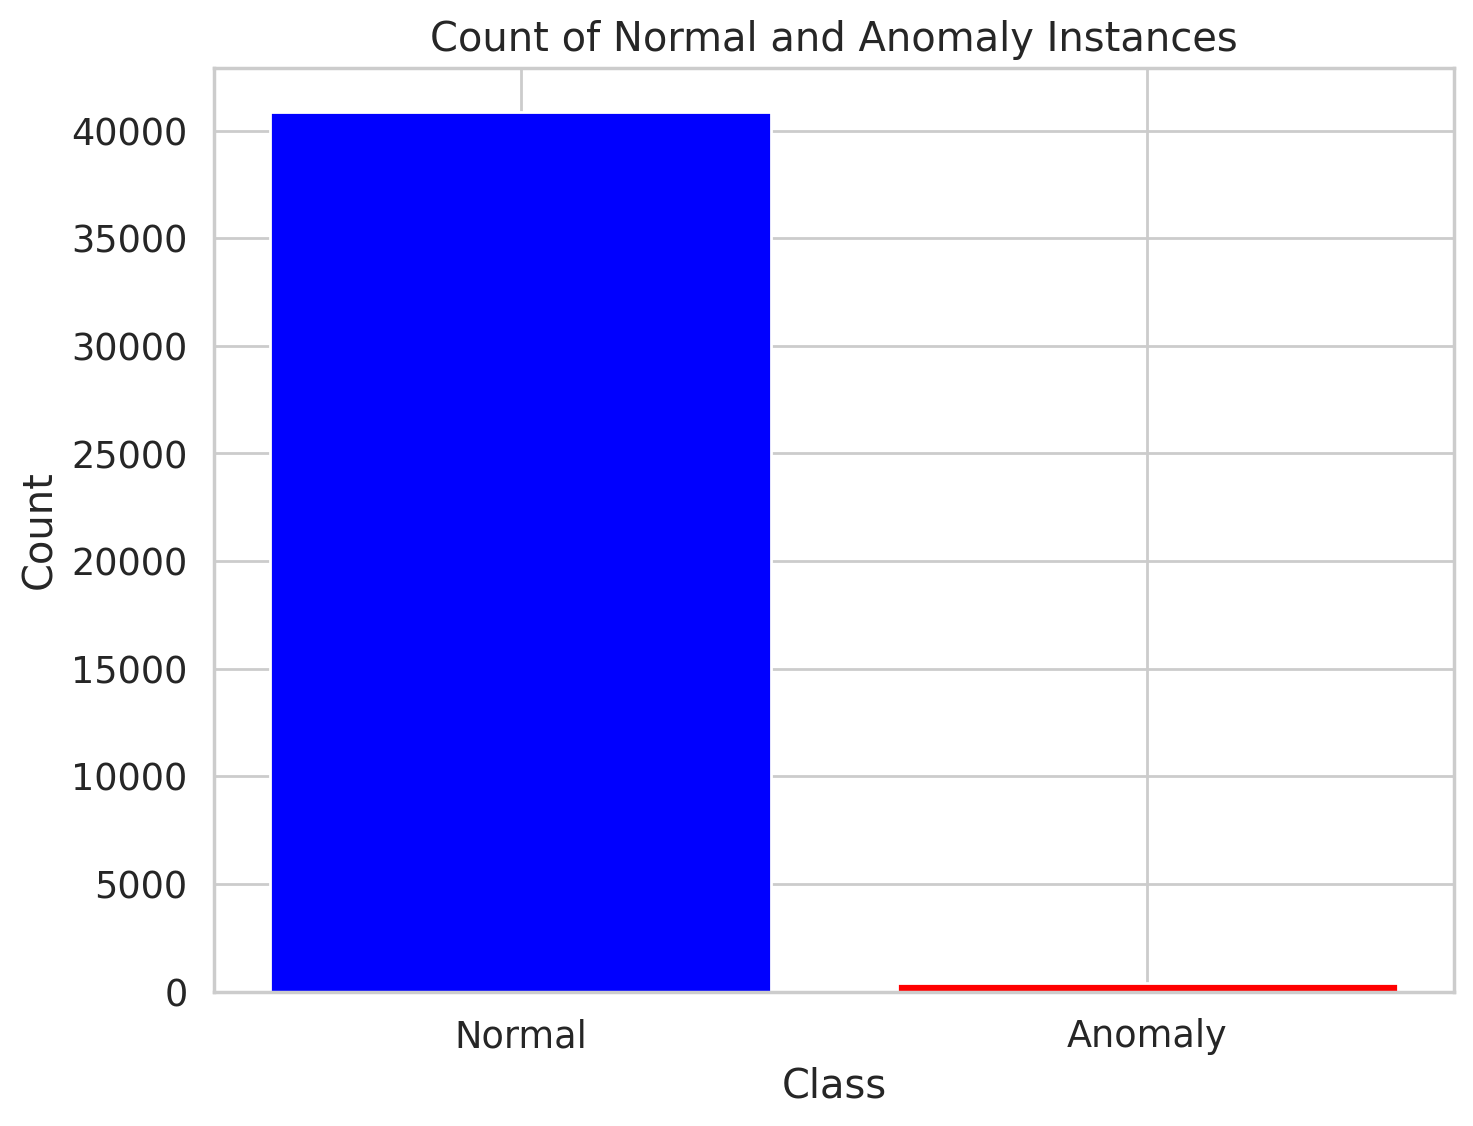

In [ ]:
# Define class names
class_names = ["Normal", "Anomaly"]

# Get value counts for 'truth' column
truth_counts = df_working['truth'].value_counts()

# Map the counts to class names
class_counts = [truth_counts.get(i, 0) for i in range(len(class_names))]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Normal and Anomaly Instances')
plt.show()

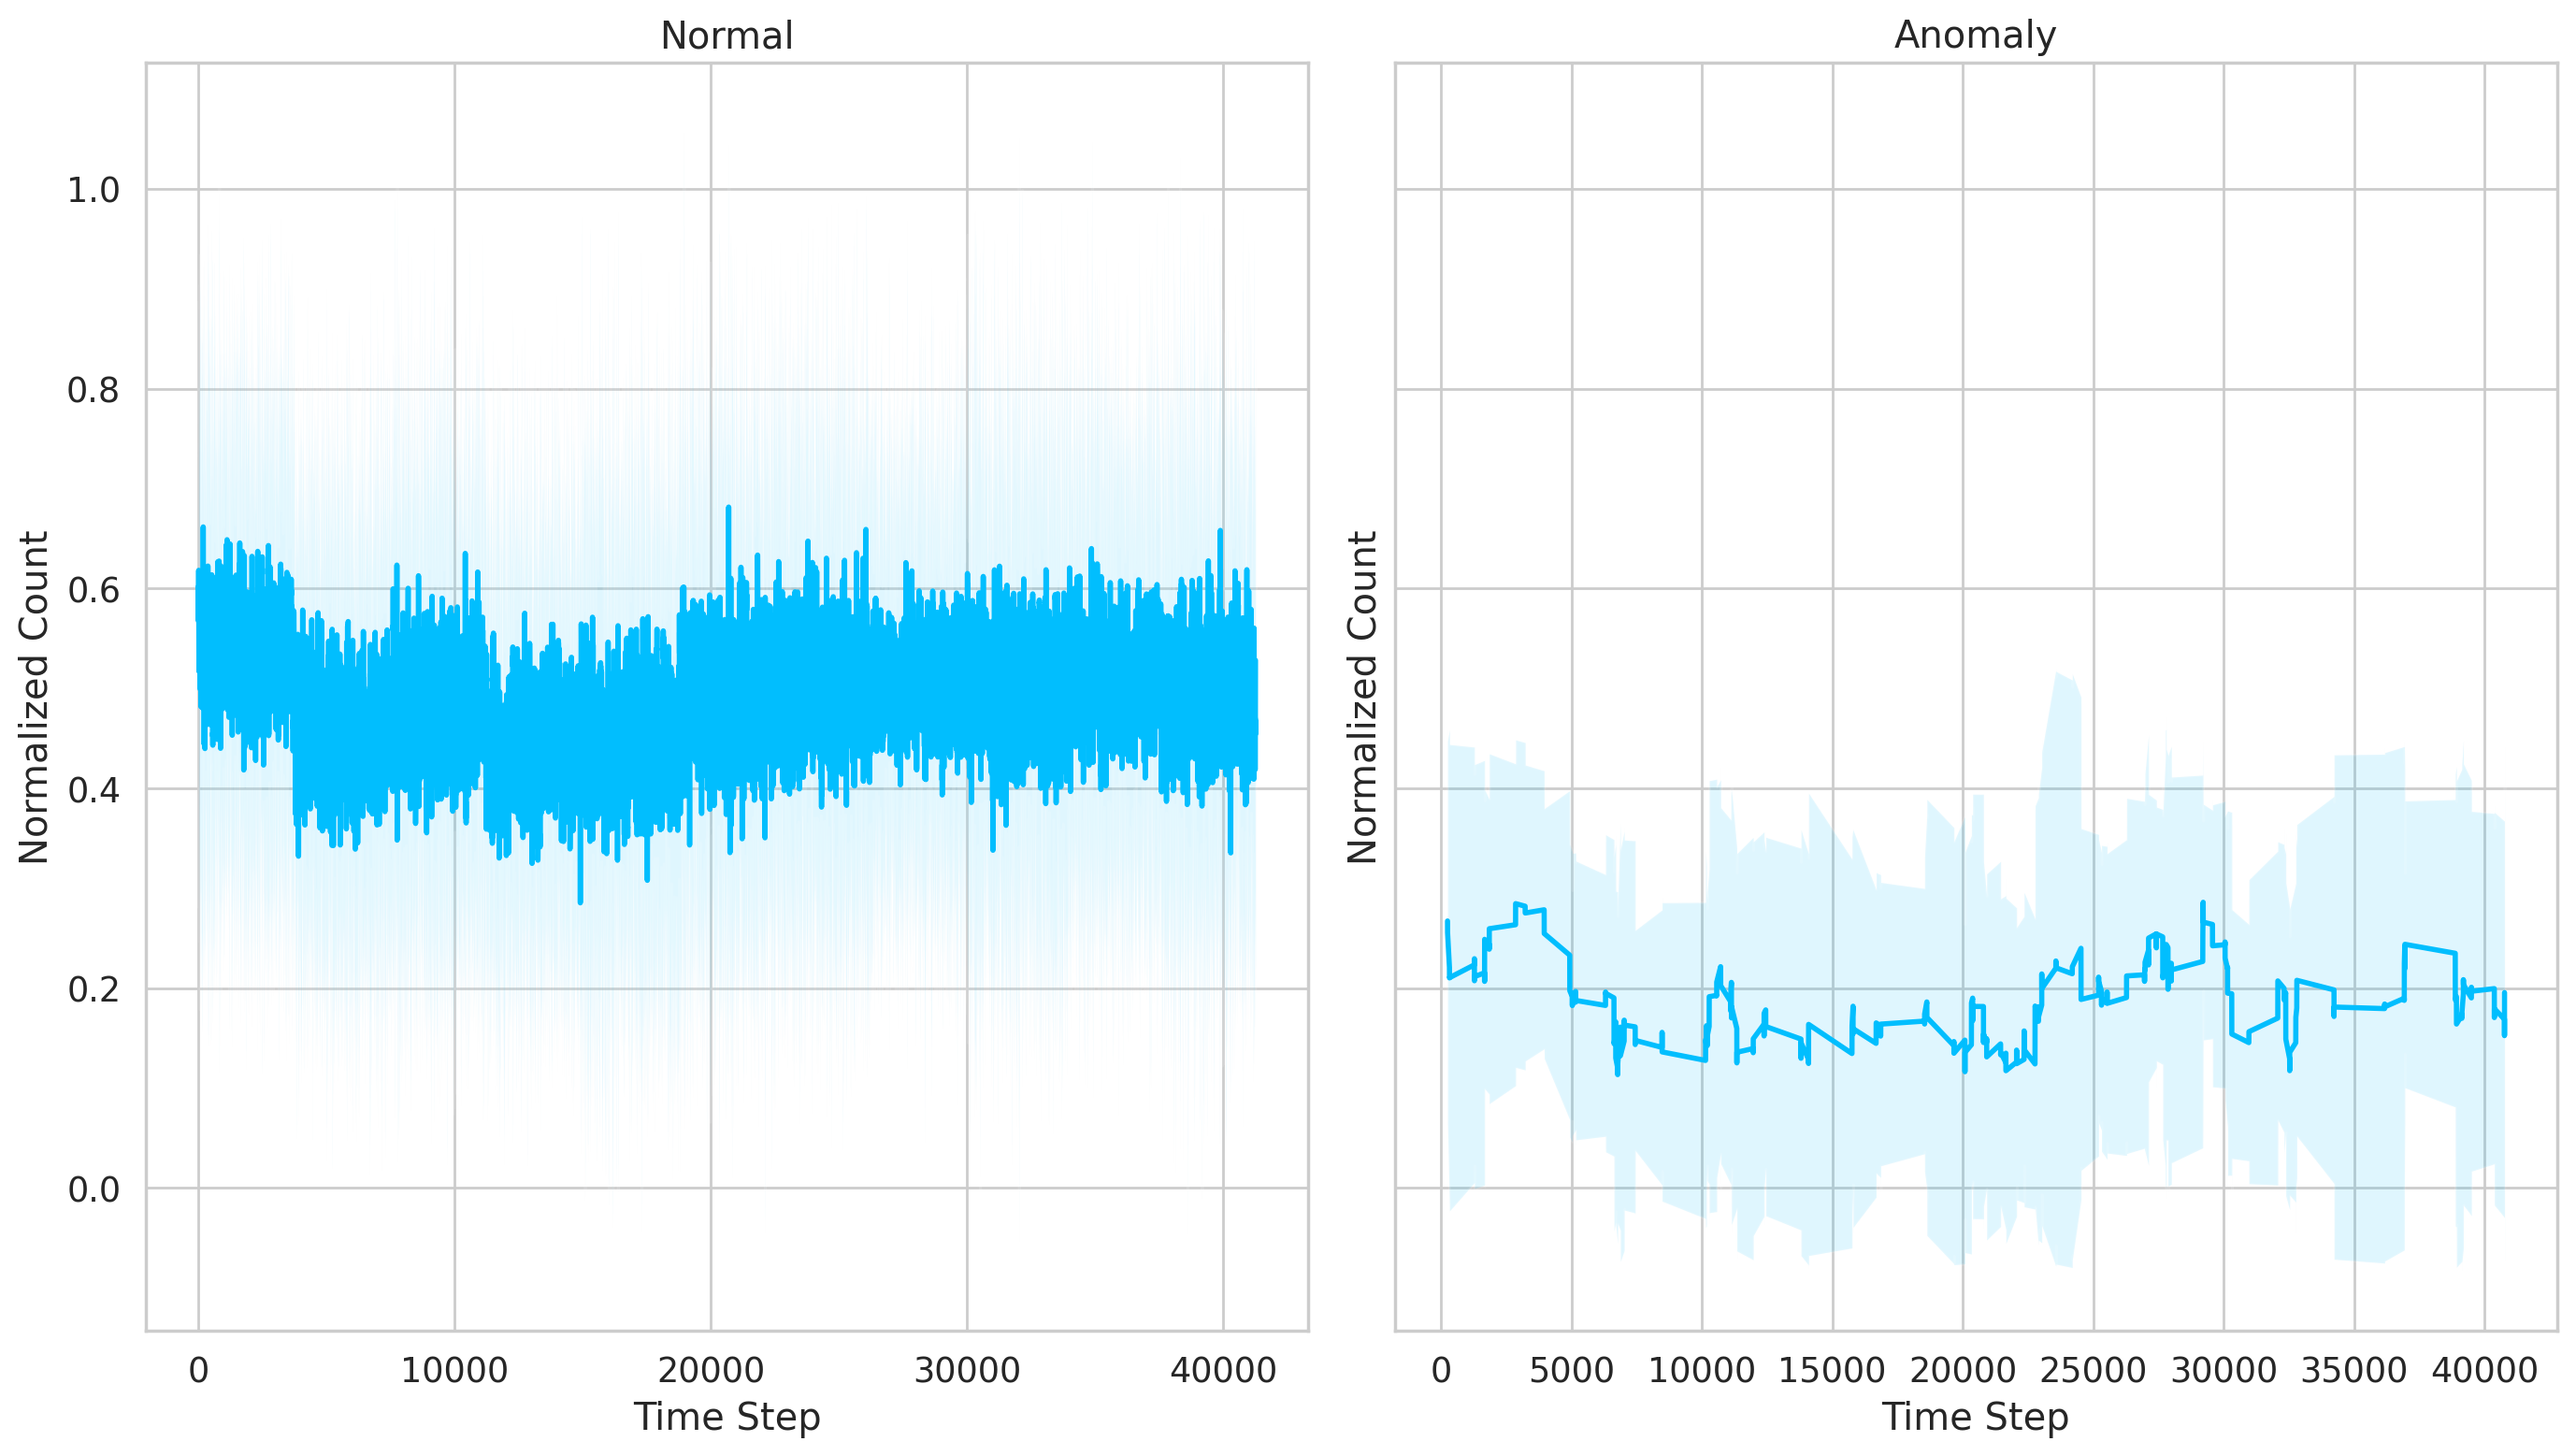

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the function to plot time series for each class
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data, columns=['normalized_count'])

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)['normalized_count']
    over_line = (smooth_path + path_deviation)['normalized_count']

    ax.plot(smooth_path['normalized_count'], linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Normalized Count')

# Define class names
class_names = ["Normal", "Anomaly"]

# Get unique classes
classes = df_working['truth'].unique()

# Create subplots
fig, axs = plt.subplots(
    nrows=(len(classes) // 3) + 1,
    ncols=2,
    sharey=True,
    figsize=(14, 8)
)

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Plot each class
for i, cls in enumerate(classes):
    ax = axs[i]
    data = df_working[df_working['truth'] == cls][['normalized_count']]
    plot_time_series_class(data, class_names[cls], ax)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()


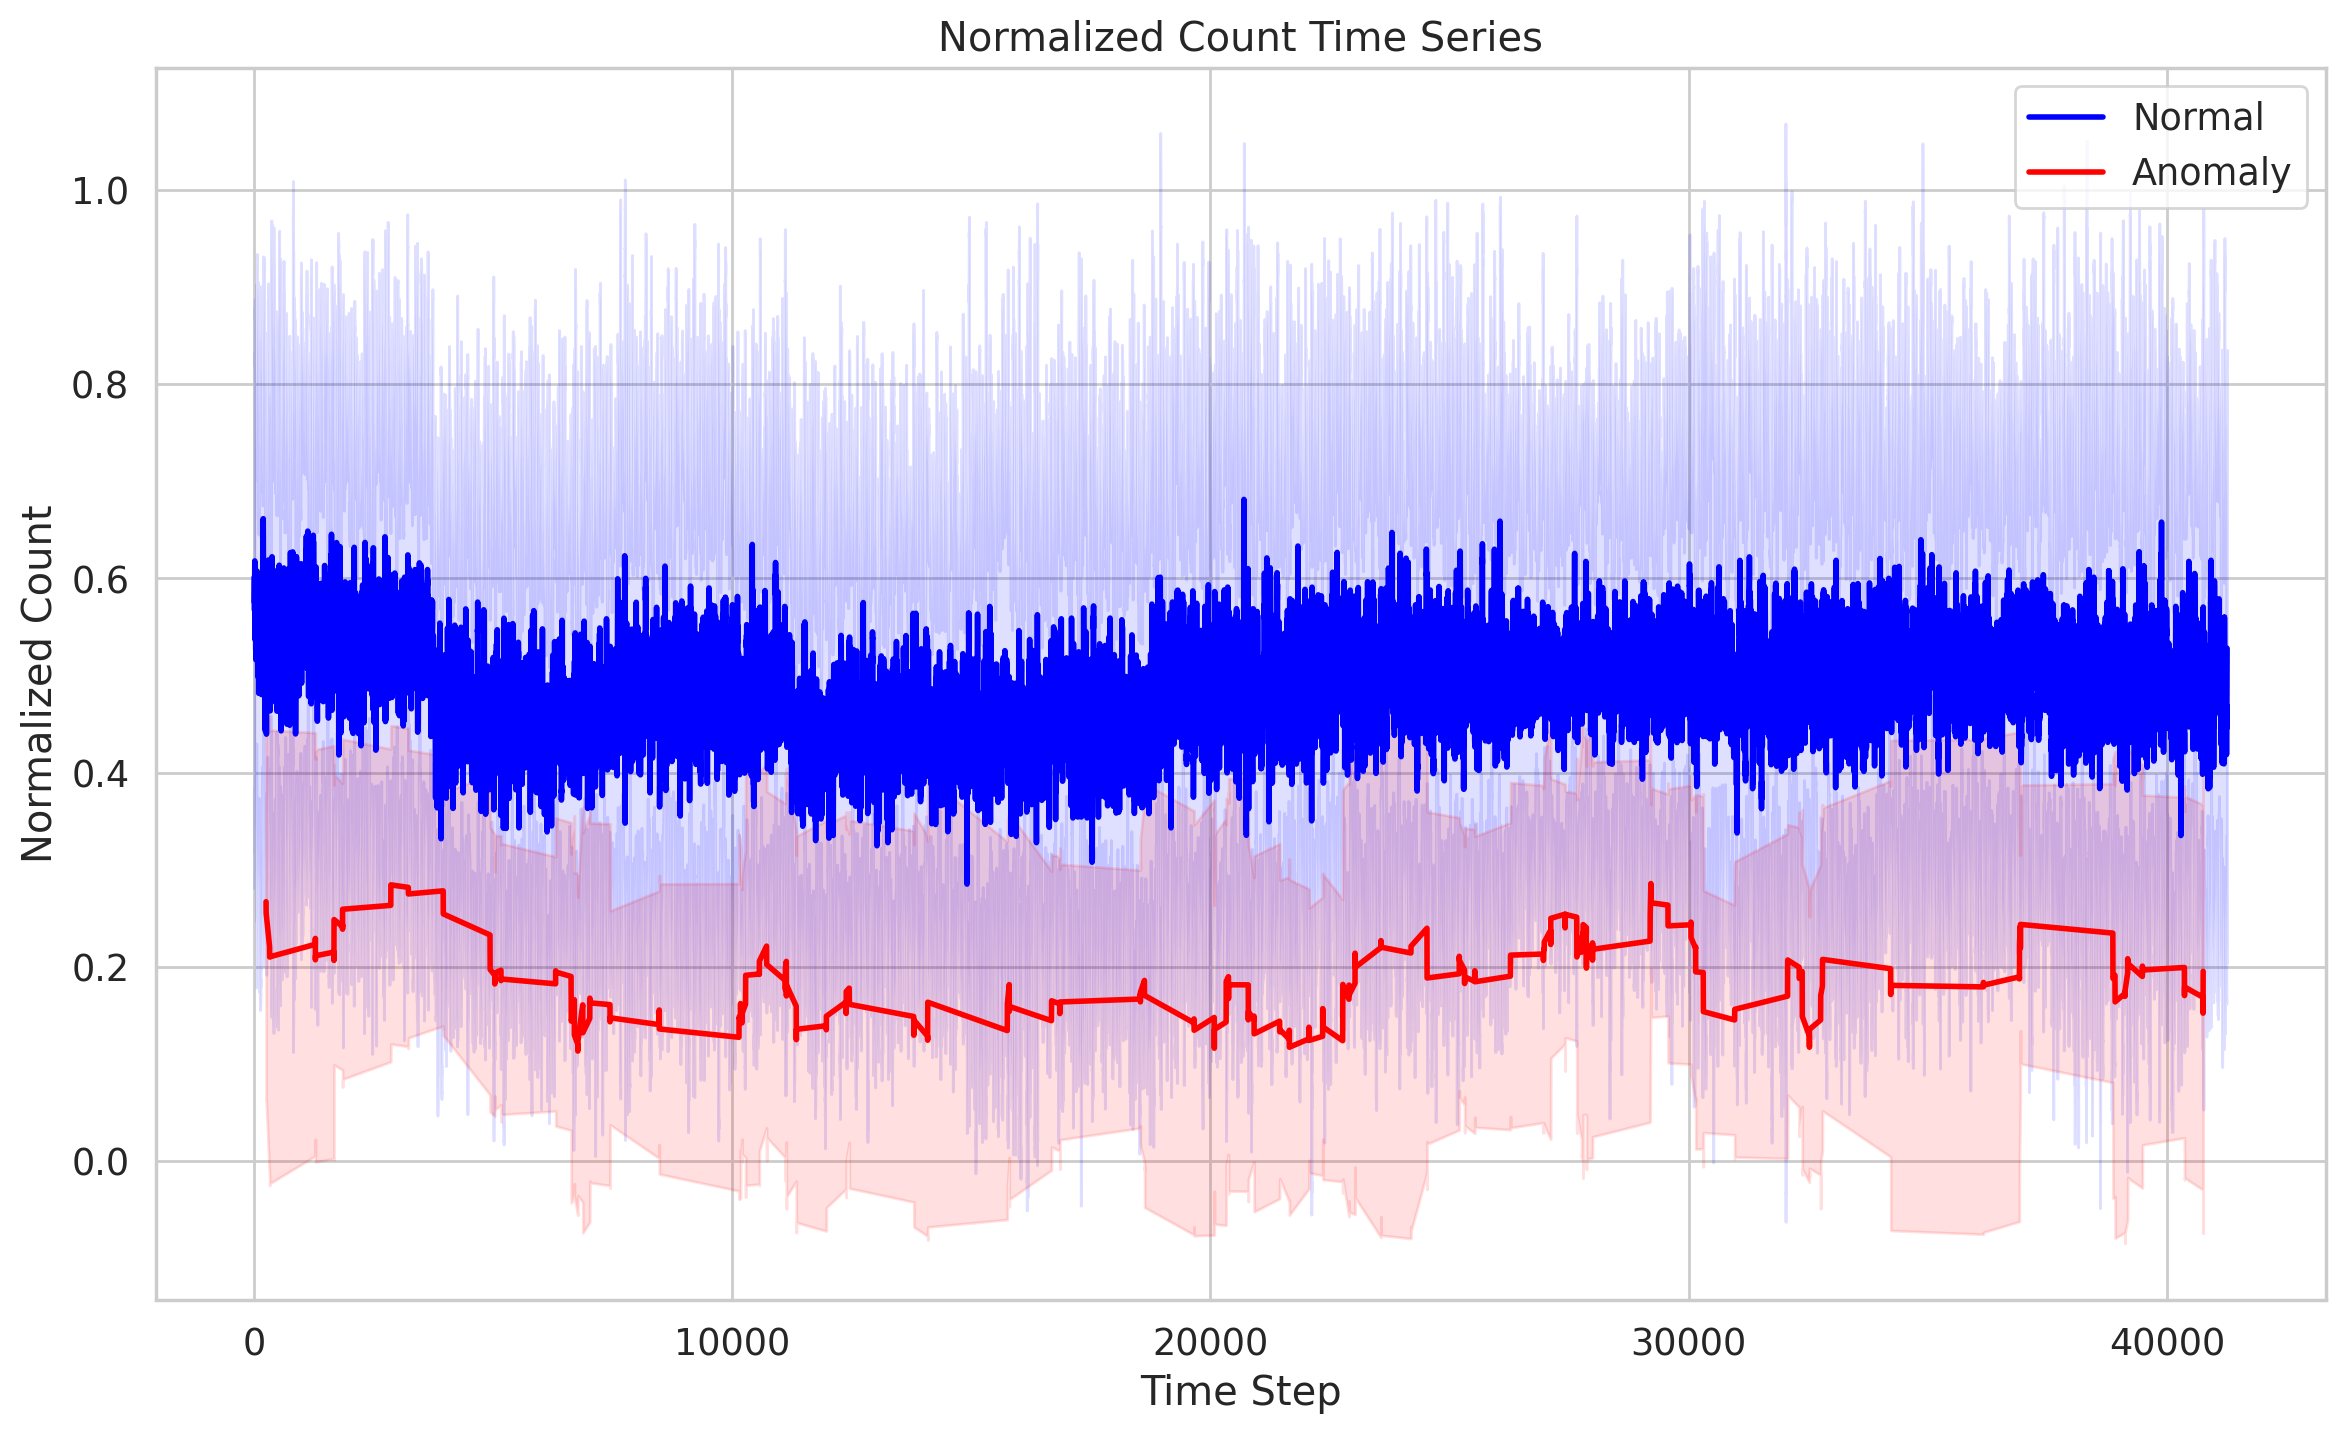

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the function to plot time series for both classes on the same graph
def plot_time_series_combined(df_working, n_steps=10):
    fig, ax = plt.subplots(figsize=(14, 8))

    for cls, color, label in zip([0, 1], ['blue', 'red'], ['Normal', 'Anomaly']):
        data = df_working[df_working['truth'] == cls][['normalized_count']]
        time_series_df = pd.DataFrame(data, columns=['normalized_count'])

        smooth_path = time_series_df.rolling(n_steps).mean()
        path_deviation = 2 * time_series_df.rolling(n_steps).std()

        under_line = (smooth_path - path_deviation)['normalized_count']
        over_line = (smooth_path + path_deviation)['normalized_count']

        ax.plot(smooth_path['normalized_count'], color=color, linewidth=2, label=label)
        ax.fill_between(
            path_deviation.index,
            under_line,
            over_line,
            color=color,
            alpha=.125
        )

    ax.set_title('Normalized Count Time Series')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Normalized Count')
    ax.legend()
    plt.show()

# Call the function with the df_working DataFrame
plot_time_series_combined(df_working)


#Data Processing

Get the normal observations

In [ ]:
normal_df = df_working[df_working['truth'] != 1].copy()


# Display the first few rows of the new DataFrame to verify
print(normal_df.head())
normal_df.shape

   normalized_count  truth
0          0.375773      0
1          0.505468      0
2          0.646931      0
3          0.563854      0
4          0.561202      0


(40885, 2)

Get the anomalies

In [ ]:
anomaly_df = df_working[df_working['truth'] == 1].copy()


# Display the first few rows of the new DataFrame to verify
print(anomaly_df.head())
anomaly_df.shape

     normalized_count  truth
74           0.275860      1
75           0.334813      1
76           0.348813      1
77           0.248910      1
131          0.322621      1


(376, 2)

We'll split the normal examples into train, validation and test sets:

In [ ]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

create datasets

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The Encoder uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a Decoder:

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128).to(device)
model = model.to(device)

#Training

this is a helper function for our training process

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [ ]:
# model, history = train_model(
#   model,
#   train_dataset,
#   val_dataset,
#   n_epochs=100
# )

In [ ]:
# ax = plt.figure().gca()

# ax.plot(history['train'])
# ax.plot(history['val'])
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'])
# plt.title('Loss over training epochs')
# plt.show();

#Saving the Model

Storing the model for later use

In [ ]:
model_path = 'model.pth'
model = torch.load(model_path, map_location=device)

# Evaluate the loaded model
model.eval()

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

#Choosing a Threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

<ipython-input-39-b1e9518eed74>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


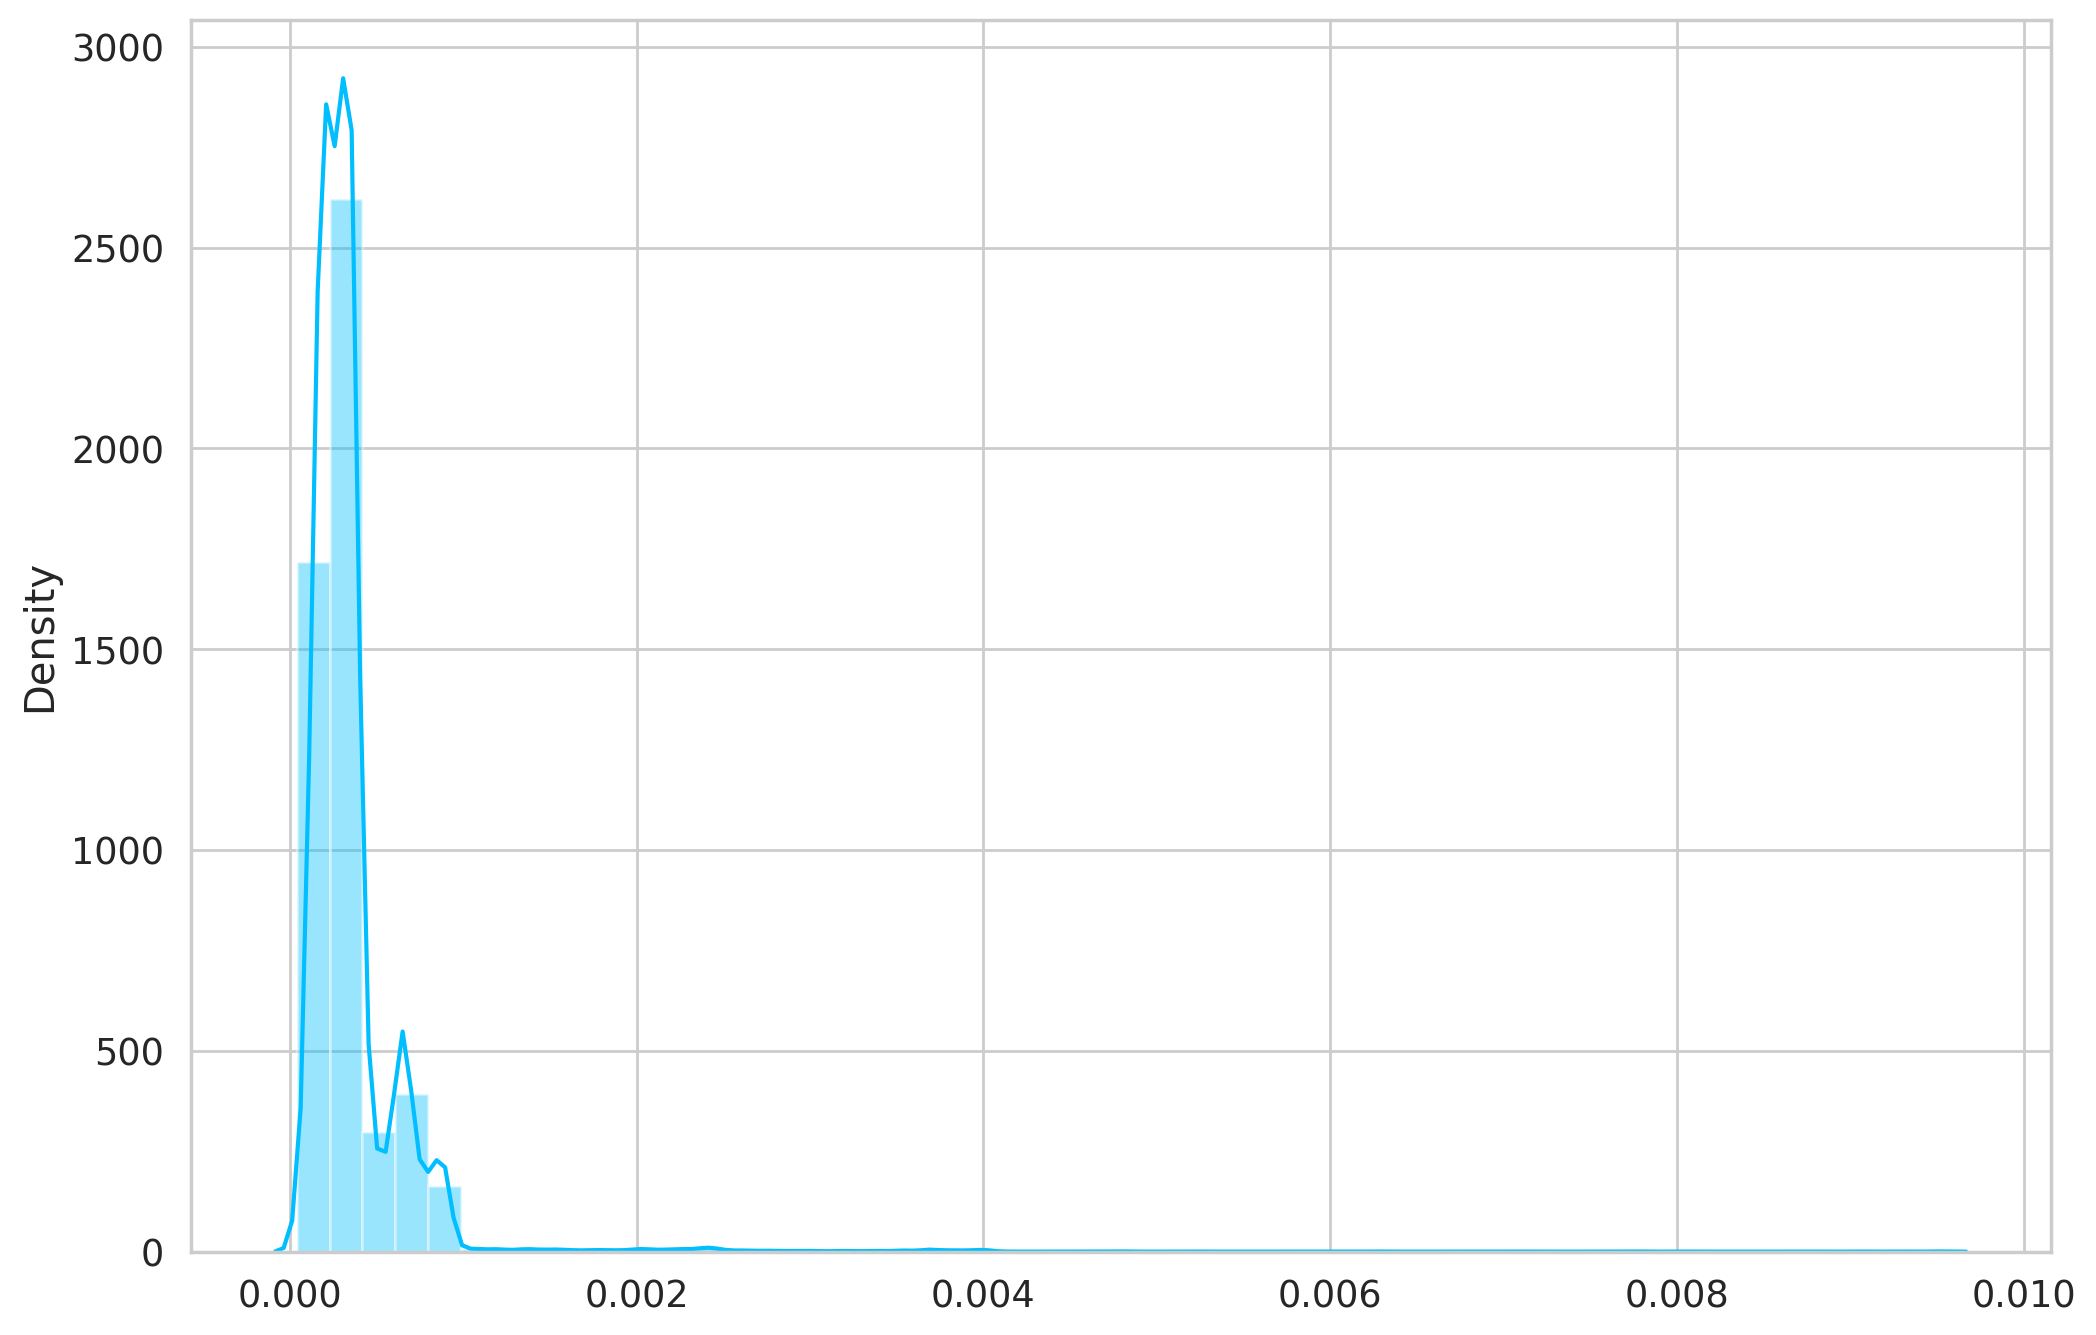

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 0.004

#Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

If the reconstruction loss for an example is below the threshold, we'll classify it as a normal obs
Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

<ipython-input-48-082c44bf687c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


Text(0, 0.5, 'Frequency')

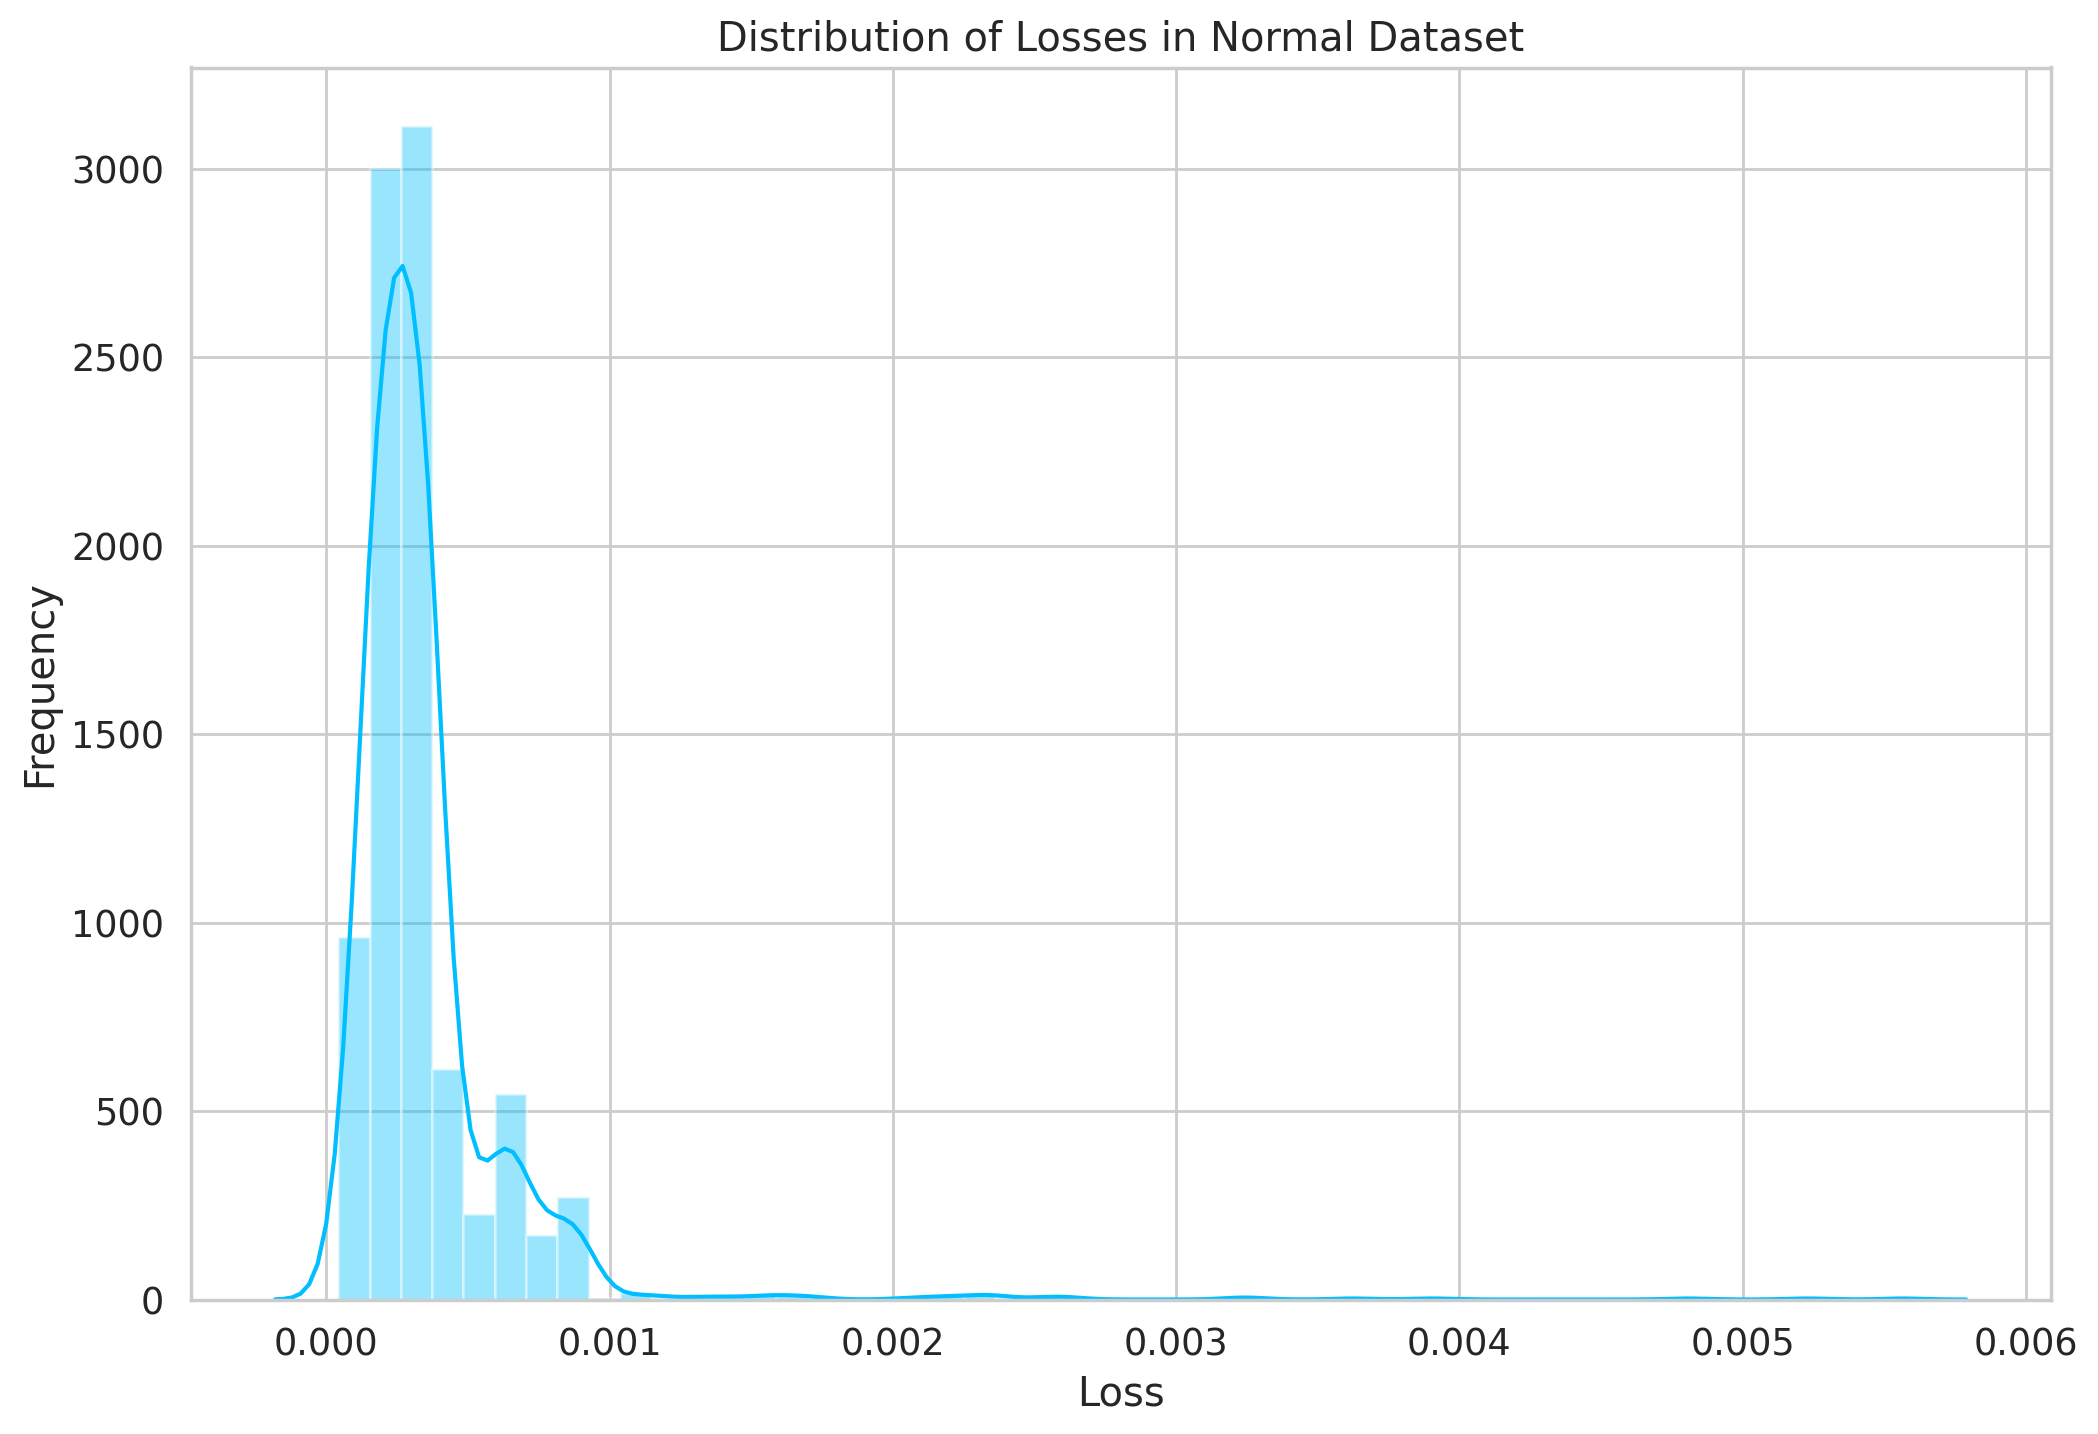

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);
plt.title('Distribution of Losses in Normal Dataset')
plt.xlabel('Loss')
plt.ylabel('Frequency')

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 2021/2024


#Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal obs:

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

<ipython-input-51-5a7a3a410b88>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True, color='red');


Text(0, 0.5, 'Frequency')

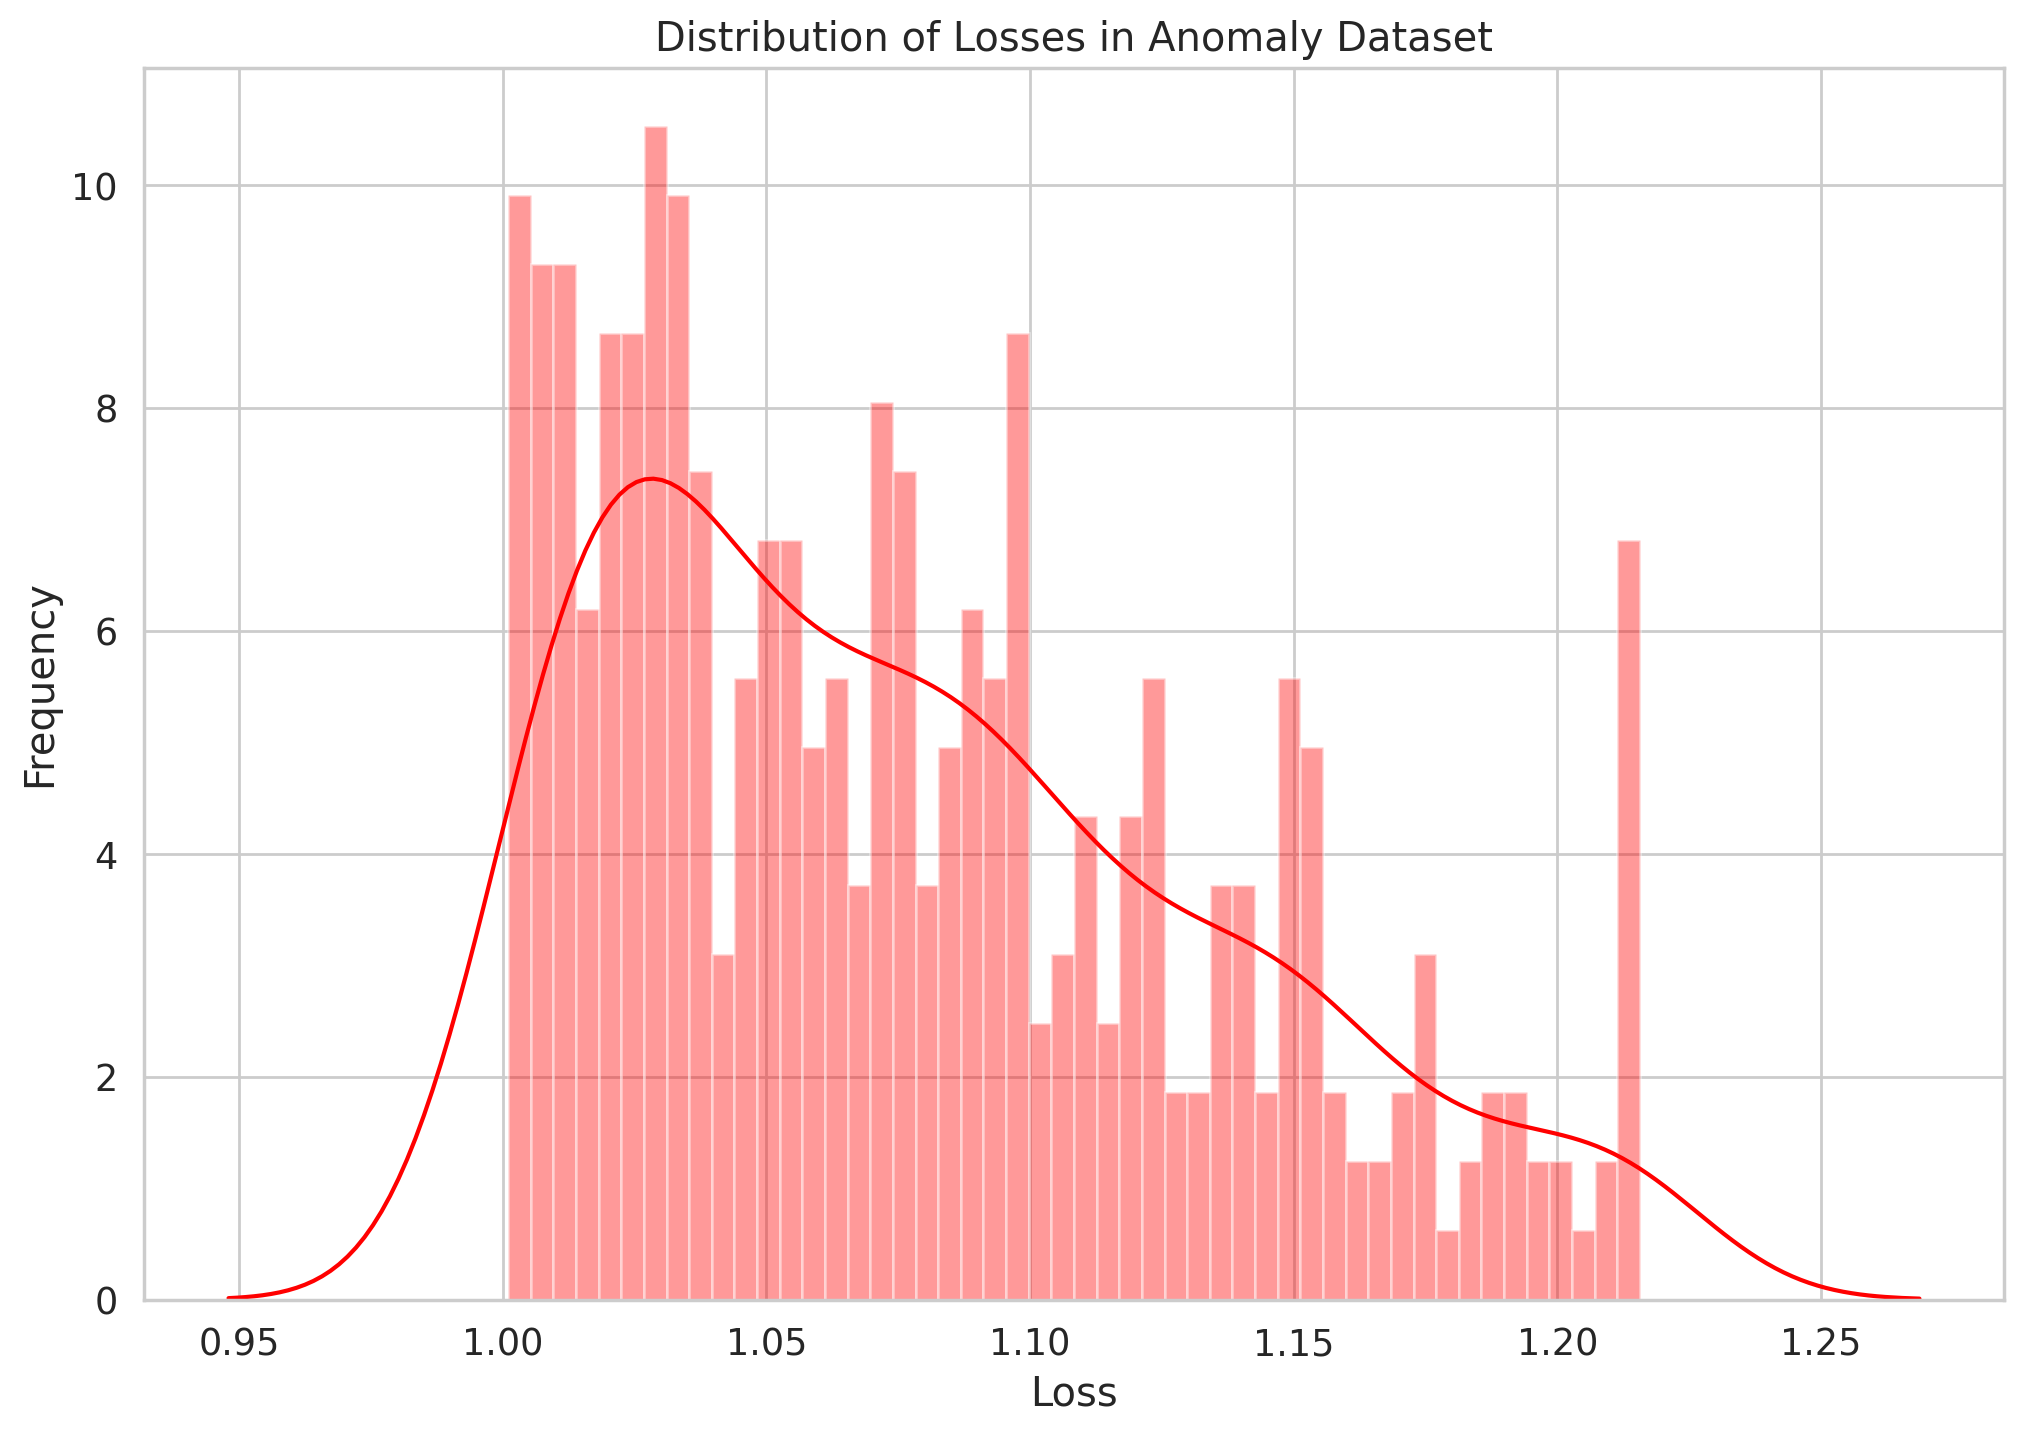

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True, color='red');
plt.title('Distribution of Losses in Anomaly Dataset')
plt.xlabel('Loss')
plt.ylabel('Frequency')

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 376/376


In [ ]:
# Printing shape
print("Shape of pred_losses:", len(pred_losses))

# Printing headers
print("Headers:", pred_losses[0])

Shape of pred_losses: 376
Headers: 1.0143781900405884


<ipython-input-56-031b2fb00bf6>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses_normal, bins=50, kde=True, ax=axs[0])
<ipython-input-56-031b2fb00bf6>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses_anomaly, bins=50, kde=True, color='red', ax=axs[1])


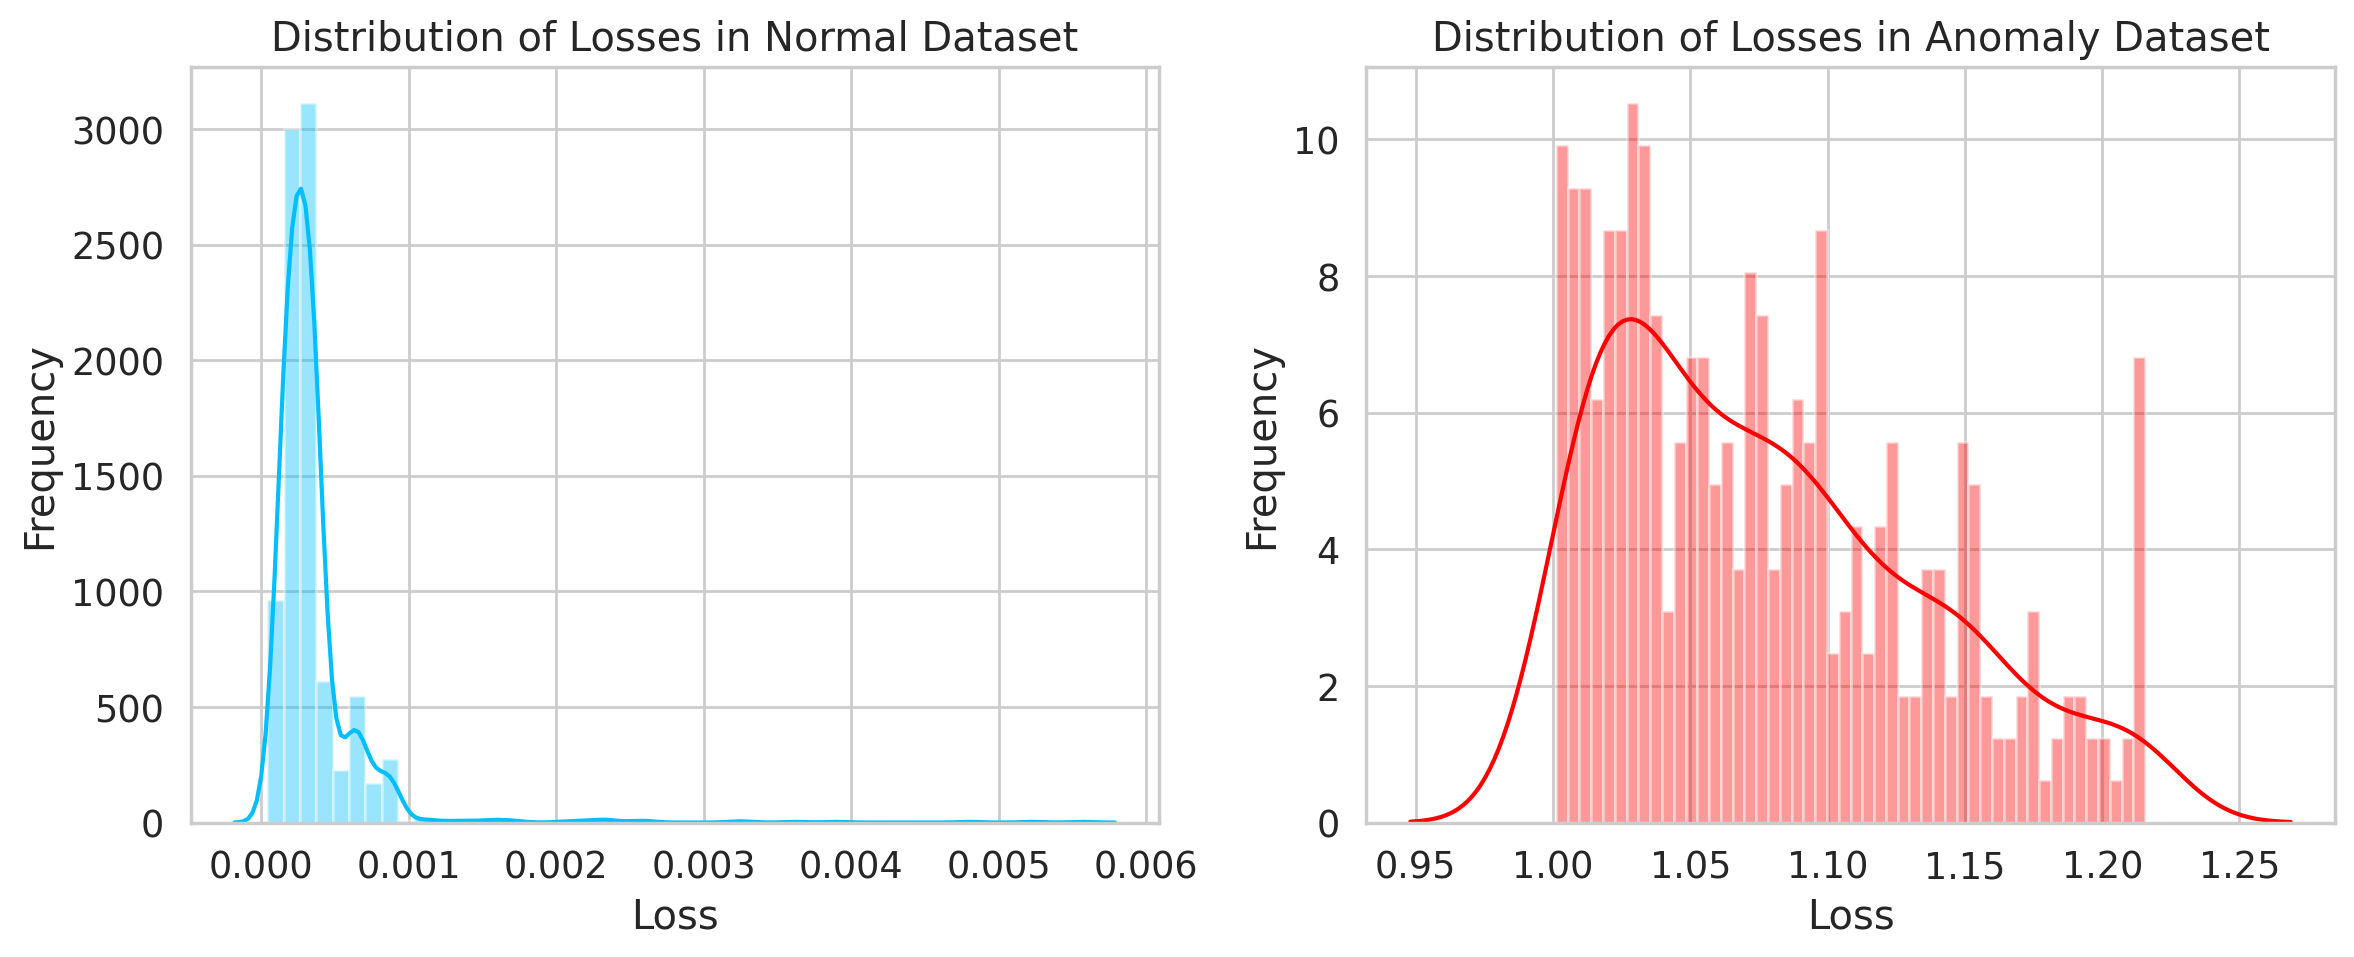

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions and losses for anomaly dataset
predictions_anomaly, pred_losses_anomaly = predict(model, anomaly_dataset)

# Predictions and losses for normal dataset
predictions_normal, pred_losses_normal = predict(model, test_normal_dataset)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot distribution of losses in normal dataset
sns.distplot(pred_losses_normal, bins=50, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Losses in Normal Dataset')
axs[0].set_xlabel('Loss')
axs[0].set_ylabel('Frequency')


# Plot distribution of losses in anomaly dataset
sns.distplot(pred_losses_anomaly, bins=50, kde=True, color='red', ax=axs[1])
axs[1].set_title('Distribution of Losses in Anomaly Dataset')
axs[1].set_xlabel('Loss')
axs[1].set_ylabel('Frequency')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
